In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from nilearn import datasets
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import resample_to_img
from nilearn.connectome import ConnectivityMeasure
import nibabel as nb
from sklearn.covariance import GraphicalLassoCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
atlas_nii = {
    'schaefer': f'Reslice_100Parcels_7Networks.nii.gz',
    'tian_subcortex': 'Reslice_tian_subcortex_S2_7T.nii.gz',
    'cerebellum': 'Reslice_MDTB10-cerebellum.nii.gz',
    'brainstem': 'brainstem_54.csv',
}

## Convert fMRI images into time series

In [3]:
# Load the functional dataset
data = datasets.fetch_adhd(n_subjects=1)
func_img = nb.load(data.func[0])

# Initialize a list to store time series
all_time_series = []

# Initalize list to store brainstem ROIs that cannot be mapped 
unmappable_brainstem_rois = []

# Define a function to process functional data into time series using brainstem atlas for parcellation
def process_brainstem_atlas(brainstem_csv_path):
    brainstem_csv = pd.read_csv(brainstem_csv_path)
    brainstem_files = [os.path.join('../atlases', 'resampled_rois', f'{label}.nii.gz') for label in brainstem_csv['Label Name']]
    brainstem_time_series_list = []
    for brainstem_file in brainstem_files:
        brainstem_img = nb.load(brainstem_file)
        resampled_brainstem_img = resample_to_img(source_img=brainstem_img, target_img=func_img, interpolation='nearest')
        masker = NiftiLabelsMasker(resampled_brainstem_img, standardize="zscore_sample", standardize_confounds="zscore_sample")
        time_series_i = masker.fit_transform(data.func[0], confounds=data.confounds)
        if time_series_i.shape[1] == 0:
            unmappable_brainstem_rois.append(brainstem_file)
        brainstem_time_series_list.append(time_series_i)
    return np.hstack(brainstem_time_series_list)

# Define a function to process functional data into time series using other atlases for parcellation
def process_other_atlas(atlas_file_path):
    atlas_img = nb.load(atlas_file_path)
    resampled_atlas_img = resample_to_img(source_img=atlas_img, target_img=func_img, interpolation='nearest')
    masker = NiftiLabelsMasker(resampled_atlas_img, standardize="zscore_sample", standardize_confounds="zscore_sample")
    return masker.fit_transform(data.func[0], confounds=data.confounds)

# Process each atlas
for atlas_name, atlas_path in atlas_nii.items():
    if atlas_name == 'brainstem':
        brainstem_csv_path = os.path.join('../atlases', atlas_path)
        time_series = process_brainstem_atlas(brainstem_csv_path)
    else:  # For schaefer, subcortex, or cerebellum
        atlas_file_path = os.path.join('../atlases', atlas_path)
        time_series = process_other_atlas(atlas_file_path)
    
    all_time_series.append(time_series)

# Concatenate time series from all parcellations
concat_time_series = np.hstack(all_time_series)

In [4]:
# Get the labels of the unmappable brainstem ROIs
unmappable_labels = []
for roi_file_path in unmappable_brainstem_rois:

    # Get the base name (file name with extension)
    file_name_with_ext = os.path.basename(roi_file_path)

    # Split the base name to handle double extensions (like .nii.gz)
    file_name, ext = os.path.splitext(file_name_with_ext)
    if ext == '.gz':  # Handle double extensions
        file_name, ext = os.path.splitext(file_name)
    unmappable_labels.append(file_name)

# Remove the unmappable brainstem ROIs from the dataframe containing ROIs of atlases used for parcellation and save result as new dataframe
df_roi_list = pd.read_csv('../roi_list_198.csv')
df_roi_list_filtered = df_roi_list[~df_roi_list['label'].isin(unmappable_labels)]
n_unmappable = len(unmappable_labels)
n_parcels = 198 - n_unmappable
df_roi_list_filtered.to_csv(f'../roi_list_{n_parcels}.csv', index=False)

## Compute a precision matrix from time series

In [5]:
warnings.filterwarnings('ignore')

# Compute a functional connectivity matrix from the time series with sparse inverse covariance (i.e., a precision matrix - every connection is direct)
estimator = GraphicalLassoCV()
estimator.fit(concat_time_series)
precision_mat = -estimator.precision_

# Make self connections 0 and save 
np.fill_diagonal(precision_mat, 0)
np.savetxt('../precision_mat.txt', precision_mat)

## Compute a correlation matrix from time series

In [6]:
warnings.filterwarnings('ignore')

# Compute a correlation matrix from the time series
correlation_measure = ConnectivityMeasure(kind="correlation")
corrmat = correlation_measure.fit_transform([concat_time_series])[0]

# Transform the correlation values to Fisher z-scores    
corrmat_fishZ = np.arctanh(corrmat)

# Make self connections 0 and save 
np.fill_diagonal(corrmat_fishZ, 0)
np.savetxt('../corrmat.txt', corrmat_fishZ)

## Plot heatmaps of the correlation and precision matrices

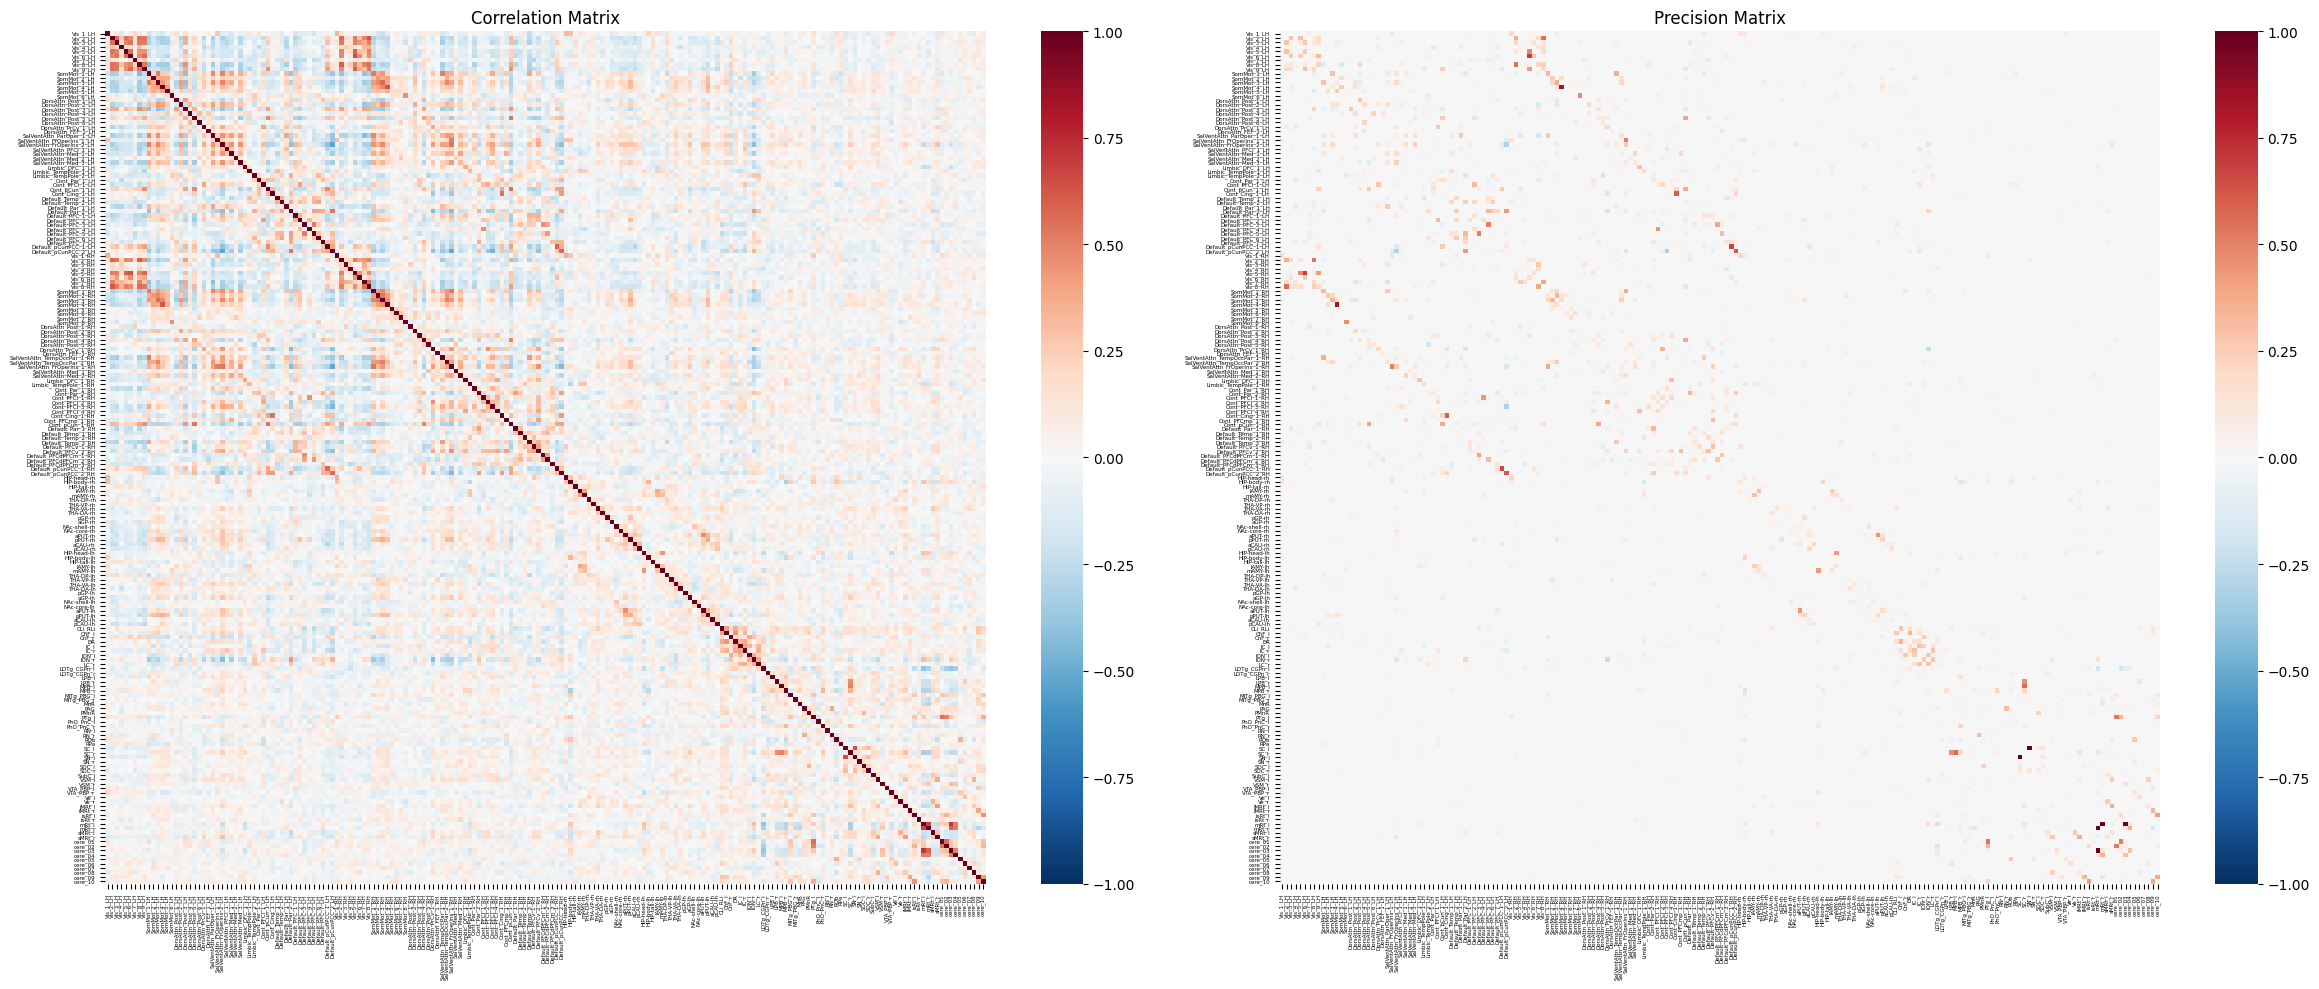

In [7]:
labels = df_roi_list_filtered['label'].values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

sns.heatmap(corrmat, cmap='RdBu_r', vmax=1, vmin=-1, cbar=True, xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_xticklabels(labels, rotation=90, fontsize=4)
ax1.set_yticklabels(labels, rotation=0, fontsize=4)
ax1.set_title('Correlation Matrix')

sns.heatmap(precision_mat, cmap='RdBu_r', vmax=1, vmin=-1, cbar=True, xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_xticklabels(labels, rotation=90, fontsize=4)
ax2.set_yticklabels(labels, rotation=0, fontsize=4)
ax2.set_title('Precision Matrix')

plt.tight_layout()
plt.show()